# Tunner

In [1]:
import pyaudio
import wave
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
chunk = 1024                            # Record in chunks of 1024 samples (2**10)
sample_format = pyaudio.paInt16         # a 16 bits integer per sample
channels = 1                            # 1 mono, 2 stereo
fs = 51200                              # Record at these samples per second
seconds = 2                             # Total recording time
T = chunk/fs                            # chunk duration .02 sec
fmax_chunk = round(chunk/2)             # max frequency in the frequency domain (512) per each chunk
fmax = fs*seconds//2                    # max freuqncy in the frequency domain of the hole record (25600)
f_idx_ch = np.arange(0,fmax_chunk)/T    # frequencies in the freq domain for each chunk
f_idx = np.arange(0,fmax)/seconds       # frequencies in the frequency domian. (np.fft.fftfreq(fs*seconds,d=1/fs)[0:fs*seconds//2-1])
runway_time = 3                         # secs to throw away before start recording
start_amp = 500                         # min amplitud to start recording 

## Musical notes and Tunner funciton

In [3]:
notes_nm = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
notes_fr = np.zeros(12*8)
notes_rate = 2**(1/12) 
notes_df = pd.DataFrame(columns = ['name','frec'])

for j in range(8):
    for i in range(12):
        if i>=3:
            oct_idx = j+1
        else:
            oct_idx = j
        new_note = pd.DataFrame([[notes_nm[i]+'-'+str(oct_idx), 27.5*(notes_rate)**(i+j*12)]] ,columns = ['name','frec'])
        notes_df=notes_df.append(new_note, ignore_index=True)

def tunner(frec):
    if frec < 27.5:
        return 'Too Low'
    else: 
        for j in range(8):
            if frec < 27.5*2**(1/24)*(notes_rate)**(j*12)*2:
                for i in range(12):
                    if frec < 27.5*2**(1/24)*(notes_rate)**(i+j*12):
                        return "{} ~{:.0%}".format(notes_df.loc[i+j*12,['name']].values[0] , 
                                                   np.log2(frec/notes_df.loc[i+j*12,['frec']].values[0])*12)
    return 'Too High'          

In [4]:
notes_df[0:50]

,name,frec
0,A-0,27.500000
1,A#-0,29.135235
2,B-0,30.867706
3,C-1,32.703196
4,C#-1,34.647829
5,D-1,36.708096
6,D#-1,38.890873
7,E-1,41.203445
8,F-1,43.653529
9,F#-1,46.249303


## Play a Signal

In [19]:
#Plays a wave in numeric fornat assuming the rate, channels and format used in the whole notebook. 
def Play(my_signal):
    p = pyaudio.PyAudio()
    stream_2 = p.open(format = sample_format,
                    channels = channels,
                    rate = fs,
                    output = True)
    stream_2.write(my_signal.tobytes())
    stream_2.stop_stream()
    stream_2.close()
    p.terminate()

## Creating a Sound

In [264]:
#this functoin uses the inverse fourier transformation to create a signal using the frequescies
#the limitation is that it rounds the frequencies to make them fit in the input of the fourier transform
#the magnitudes here are scaled down to fit the maximum capacity of the Int16 format

def Create_signal(frec_arr,amp_arr):
    t_s = np.zeros(fs*seconds, dtype=np.int16)
    count = 0
    for i in (frec_arr):
        t_s[int(i*seconds)]=amp_arr[count]
        count+=1
    for i in range(1,int(len(t_s)/2),1):
        t_s[-i]=t_s[i]
    count = 0
    signal_=np.real(np.fft.ifft(t_s))
    signal_*=np.iinfo(np.int16).max/max(signal_)
    x=np.arange(0,fs*seconds)
    fade= 2-2/(np.exp(-x/fs*seconds)+1)
    signal_*=fade
    signal_*=fade
    signal_=signal_.astype(np.int16)
    return signal_

#this function uses the frequencies to create a composed wave based on cos() 
#magnitudes are adjuted to max of int16 format and the output is casted as Int16 as well

def Create_signal2(frec_arr,amp_arr):
    x=np.arange(0,fs*seconds)
    t_s = np.zeros(fs*seconds, dtype=np.float64)
    for i in np.arange(len(frec_arr)):
        t_s += np.cos(x*2*np.pi*frec_arr[i]/fs)*amp_arr[i]
    t_s *=np.iinfo(np.int16).max/max(t_s)
    x2=np.arange(0,fs*seconds)
    fade= (2-2/(np.exp(-x2/fs*seconds)+1))**2
    t_s *= fade
    return t_s.astype(np.int16)

## Analyzing a Signal

In [341]:
# a function to interpolate three points and find the maximum by quadratic aproximation
# x and y are the x coordinated and the y condinates of three points

def interpolate(x,y):
    matrix=np.matrix([[x[0]**2,x[0],1],
                      [x[1]**2,x[1],1],
                      [x[2]**2,x[2],1]
                     ])
    coefs_quad = np.linalg.inv(matrix)*[[y[0]],[y[1]],[y[2]]]
    x_max = -coefs_quad.item(1,0)/2/coefs_quad.item(0,0)
    y_max = ([[x_max**2,x_max,1]]*coefs_quad).item(0,0)
    return [x_max,y_max]
    


In [525]:
#a functiono that shows how a wave looks and the harmonics on it
def describe_wave(signal):
    f_transform = np.abs(np.fft.fft(signal)[0:fmax])      # The magnitude of the fourier transform for the posive freqs 
    fig, ax = plt.subplots(2,1)                           # Create the graphics
    ax[0].plot(signal)                     # Print the signal
    ax[1].plot(np.arange(0,len(f_transform))/seconds,f_transform)                # Simple plotting. The x are multiplies by the number of seconds. 
    #ax[1].plot(pd.DataFrame({'y':f_transform, 'x': np.arange(0,len(f_transform))/seconds}))               # Print the fourier transform 
    ax[1].set_xlim(0,max(np.arange(0,len(f_transform))[f_transform>max(f_transform)/10]))
    FFT = pd.DataFrame({'f_pwr':f_transform}) 
    FFT['f_idx'] = f_idx
    FFT.set_index('f_idx',inplace=True)
    FFT['f_pwr_2']=np.concatenate((f_transform[[0]],f_transform[0:-1]))
    FFT['f_pwr_3']=np.concatenate((f_transform[1:],f_transform[[-1]]))
    
    print('Frequency: {}\n Tunner Output:{}'.format(FFT.idxmax(0)[0], tunner(FFT.idxmax(0)[0])))
    
    freq_pd = FFT.nlargest(150,'f_pwr').reset_index()
    max_freq = []
    freq_corr = []
    note = []
    for freq in freq_pd['f_idx']:
        if (FFT.loc[freq][0]>FFT.loc[freq-1/seconds][0]) and (FFT.loc[freq][0]>FFT.loc[freq+1/seconds][0]) :
            max_freq.append(1)
            inter_freq=interpolate([freq,freq-1/seconds,freq+1/seconds],FFT.loc[freq].values)[0]
            note.append(tunner(inter_freq))
            freq_corr.append(inter_freq)
        else:
            max_freq.append(0)
            note.append(0)
            freq_corr.append(0)
    freq_pd['max_freq']=max_freq
    freq_pd['note']=note
    freq_pd['f_corr']= freq_corr
    
    harm_pd=freq_pd[freq_pd['max_freq']==1].sort_values(['f_idx'])#.nlargest(25,'f_pwr')
    
    return harm_pd[['f_corr','note']]

In [541]:
Play(Create_signal2([440.25,440],[1000,1000]))

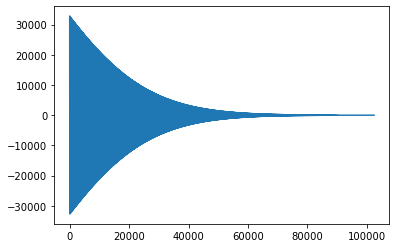

In [291]:
plt.plot(Create_signal2([440.25,440],[1000,1000]))

Frequency: 440.5
 Tunner Output:A-4 ~2%


,f_corr,note
0,440.50259,A-4 ~2%


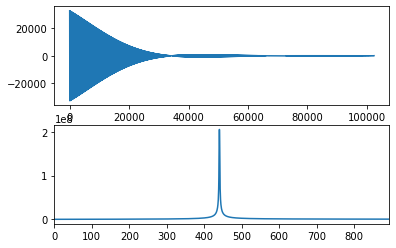

In [526]:
describe_wave(Create_signal2([440,441,440.5],[1000,1000,1000]))

In [533]:
h_footprint=pd.read_csv('footprint_C2.csv')

Frequency: 655.0
 Tunner Output:E-5 ~-11%


,f_corr,note
53,130.997833,C-3 ~2%
9,196.511834,G-3 ~5%
44,327.014101,E-4 ~-14%
38,392.518876,G-4 ~2%
5,458.029680,A#-4 ~-30%
12,589.032950,D-5 ~5%
0,655.043678,E-5 ~-11%
21,721.054364,F#-5 ~-45%
71,787.553831,G-5 ~8%
14,850.510813,G#-5 ~41%


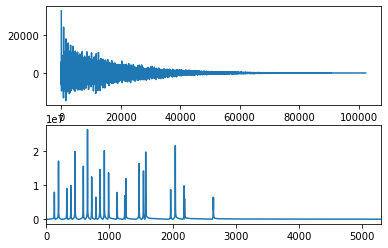

In [534]:
describe_wave(Create_signal2(h_footprint['harm']*65.406391, h_footprint['amp']))

In [546]:
Play(Create_signal2(h_footprint['harm']*440, h_footprint['amp']))

In [545]:
Play(Create_signal2([64], [1000]))

Frequency: 601.0
 Tunner Output:D-5 ~40%


,f_corr,note
10,180.291500,F#-3 ~-45%
6,420.146272,G#-4 ~20%
11,540.396247,C#-5 ~-44%
0,600.946334,D-5 ~40%
19,780.293609,G-5 ~-8%
3,844.975262,G#-5 ~30%
9,1348.124461,E-6 ~38%
15,1412.413994,F-6 ~19%
2,1444.979575,F#-6 ~-41%
1,1874.348881,A#-6 ~9%


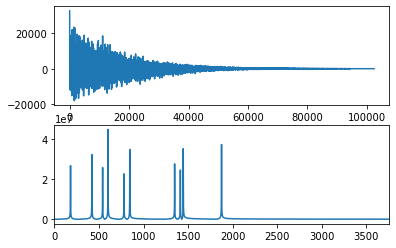

In [587]:
harm_num = 10
wave = Create_signal2(np.array(h_footprint.nlargest(harm_num,['amp'])['harm']*60),  
                      np.array(h_footprint.nlargest(harm_num,['amp'])['amp']))
Play(wave)
describe_wave(wave)

In [563]:
 np.array( h_footprint.nlargest(10,['amp'])['harm'])

array([10.01529052, 31.23853211, 24.08256881, 14.08256881,  7.0030581 ,
        3.00458716, 22.46941896,  9.00611621, 23.53975535, 13.00458716])

Frequency: 654.0
 Tunner Output:E-5 ~-14%


,f_corr,note
9,196.169598,G-3 ~2%
4,457.828903,A#-4 ~-31%
0,654.001277,E-5 ~-14%
3,915.572614,A#-5 ~-31%
2,1569.571428,G-6 ~2%
1,2027.431676,B-6 ~45%


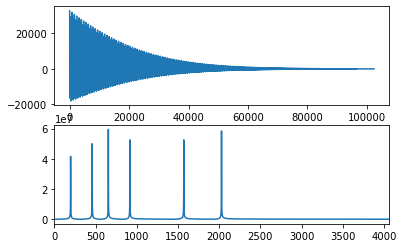

In [582]:
describe_wave(Create_signal2(np.array([10, 31, 24, 14, 7,3])*65.4, [20,20,18,18,18,15]))

In [550]:
h_footprint.sort_values('amp', ascending=False).nlargest(10, ['amp'])

,index,harm,amp
6,6,10.015291,2.418250e+06
20,20,31.238532,2.111637e+06
18,18,24.082569,1.881805e+06
11,11,14.082569,1.865553e+06
4,4,7.003058,1.821525e+06
1,1,3.004587,1.558307e+06
16,16,22.469419,1.543175e+06
5,5,9.006116,1.424606e+06
17,17,23.539755,1.344029e+06
9,9,13.004587,1.318819e+06


Frequency: 880.0
 Tunner Output:A-5 ~-0%


,f_corr,note
10,439.999066,A-4 ~-0%
0,879.999963,A-5 ~-0%
8,1320.000425,E-6 ~2%
1,1760.000454,A-6 ~0%
7,2200.001594,C#-7 ~-14%
6,2640.001508,E-7 ~2%
87,3080.007953,G-7 ~-31%
9,3520.001511,A-7 ~0%
85,3960.008527,B-7 ~4%
86,4400.006466,C#-8 ~-14%


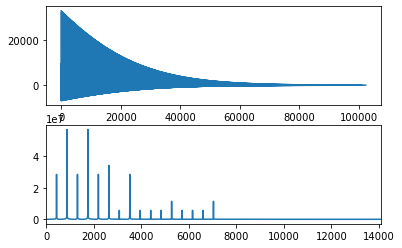

In [581]:
wave2= Create_signal2(np.array([1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])*440, [50,100,50,100,50,60,10,50,10,10,10,20,10,10,10,20])
Play(wave2)
describe_wave(wave2)

## Recording

Listening
> .Recording....................................................................................................end
Frequency: 1104.5


'C#-6 ~-7%'

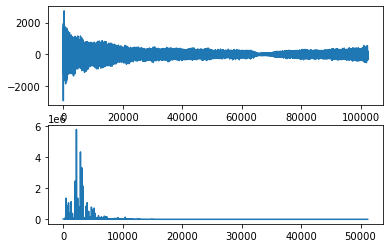

In [415]:
p = pyaudio.PyAudio()                   # Create an interface to PortAudio
stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)
frames = []                             # Initialize array to store frames

print(" ",end="")                       # Cicle of 3 secs to drop clicking noise when the audio starts
for j in range (0,runway_time+1):
    for i in range(0, int(fs / chunk)):
        data = stream.read(chunk)
    print("\b{}".format(runway_time-j),end="")
print("\bListening\n> ", end="")

amp =0
count=0
while amp < start_amp:                  # Listening until the amplitud is high enough to start recording 
    data = stream.read(chunk)
    amp = max(np.frombuffer(data,np.int16))-min(np.frombuffer(data,np.int16))
    count+=1
    if count%2==0:
        print("\b",end="")
    else:
        print(".", end="")

print("Recording", end="")
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    frames.append(data)
    print(".",end="")
print("end")

frames_list = frames.copy()             # This is a copy used to work with row independently
frames = b''.join(frames)               # Concatenate all the frames in one long string in bytes
  
stream.stop_stream()                    # Stop and close the stream 
stream.close()
p.terminate()                           # Terminate the PortAudio interface

signal = np.frombuffer(frames, np.int16)              # transform the signal from bytes to integers
f_transform = np.abs(np.fft.fft(signal)[0:fmax])      # The magnitude of the fourier transform for the posive freqs 

fig, ax = plt.subplots(2,1)            # Create the graphics
ax[0].plot(signal)                     # Print the signal
ax[1].plot(f_transform)                # Print the fourier transform 

FFT = pd.DataFrame({'f_pwr':f_transform}) 
FFT['f_idx'] = f_idx
FFT.set_index('f_idx',inplace=True)
print('Frequency: {}'.format(FFT.idxmax(0)[0]))
tunner(FFT.idxmax(0)[0])

In [422]:
Play(signal)

Frequency: 1104.5
 Tunner Output:C#-6 ~-7%


,f_corr,note
103,213.071771,G#-3 ~45%
117,214.517673,A-3 ~-44%
16,221.062764,A-3 ~8%
41,330.611955,E-4 ~5%
34,440.911271,A-4 ~4%
101,550.866878,C#-5 ~-11%
27,661.029768,E-5 ~5%
128,770.794407,G-5 ~-29%
94,990.500196,B-5 ~5%
52,991.642459,B-5 ~7%


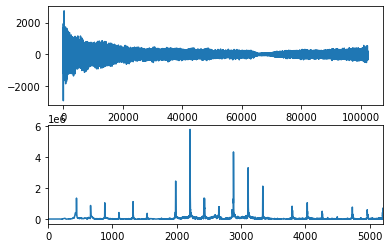

In [448]:
describe_wave(signal)

## Finding Harmonics from the fourier transform

In [407]:
FFT.nlargest(150,'f_pwr')

,f_pwr,f_pwr_2,f_pwr_3
f_idx,,,
1442.0,3.095368e+06,8.904460e+05,2.804045e+06
992.5,3.083490e+06,4.802877e+05,2.190066e+06
1442.5,2.804045e+06,3.095368e+06,1.147019e+06
1556.0,2.435905e+06,2.124995e+06,1.256873e+06
1104.5,2.337408e+06,1.476604e+06,1.544903e+06
...,...,...,...
1000.0,3.636385e+05,3.389820e+05,3.314357e+05
218.0,3.629471e+05,3.435143e+05,3.959217e+05
1108.5,3.629197e+05,4.085310e+05,3.213258e+05


In [408]:
freq_pd = FFT.nlargest(150,'f_pwr').reset_index()
max_freq = []
note = []
for freq in freq_pd['f_idx']:
    if (FFT.loc[freq][0]>FFT.loc[freq-1/seconds][0]) and (FFT.loc[freq][0]>FFT.loc[freq+1/seconds][0]) :
        max_freq.append(1)
        note.append(tunner(freq))
    else:
        max_freq.append(0)
        note.append(0)
freq_pd['max_freq']=max_freq
freq_pd['note']=note
harm_pd=freq_pd[freq_pd['max_freq']==1].sort_values(['f_idx']).nlargest(25,'f_pwr')
harm_pd

,f_idx,f_pwr,f_pwr_2,f_pwr_3,max_freq,note
0,1442.0,3.095368e+06,8.904460e+05,2.804045e+06,1,F#-6 ~-45%
1,992.5,3.083490e+06,4.802877e+05,2.190066e+06,1,B-5 ~8%
3,1556.0,2.435905e+06,2.124995e+06,1.256873e+06,1,G-6 ~-13%
4,1104.5,2.337408e+06,1.476604e+06,1.544903e+06,1,C#-6 ~-7%
12,2016.0,1.243786e+06,3.568770e+05,6.727855e+05,1,B-6 ~35%
14,991.5,1.145891e+06,5.923587e+05,4.802877e+05,1,B-5 ~7%
15,1670.0,1.100808e+06,6.634316e+05,8.973776e+05,1,G#-6 ~9%
16,1216.5,1.098202e+06,7.261430e+05,7.720015e+05,1,D#-6 ~-39%
17,221.0,1.097470e+06,9.906728e+05,9.654343e+05,1,A-3 ~8%
18,1554.0,1.066628e+06,4.341659e+05,6.190940e+05,1,G-6 ~-16%


In [409]:
harm_pd.nsmallest(10,'f_idx')

,f_idx,f_pwr,f_pwr_2,f_pwr_3,max_freq,note
17,221.0,1.097470e+06,9.906728e+05,9.654343e+05,1,A-3 ~8%
64,330.5,5.323729e+05,2.170049e+05,4.678514e+05,1,E-4 ~5%
51,441.0,6.298852e+05,5.141272e+05,4.294102e+05,1,A-4 ~4%
53,661.0,6.250677e+05,2.763845e+05,2.386919e+05,1,E-5 ~5%
43,990.5,6.788220e+05,5.864176e+05,5.923587e+05,1,B-5 ~5%
14,991.5,1.145891e+06,5.923587e+05,4.802877e+05,1,B-5 ~7%
1,992.5,3.083490e+06,4.802877e+05,2.190066e+06,1,B-5 ~8%
4,1104.5,2.337408e+06,1.476604e+06,1.544903e+06,1,C#-6 ~-7%
28,1212.0,8.049564e+05,4.850725e+05,6.544098e+05,1,D#-6 ~-46%
40,1213.0,6.900202e+05,6.544098e+05,5.363644e+05,1,D#-6 ~-44%


<AxesSubplot:xlabel='f_idx'>

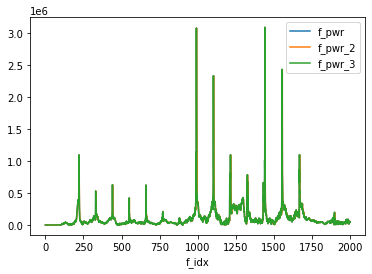

In [410]:
FFT[0:2000].plot()

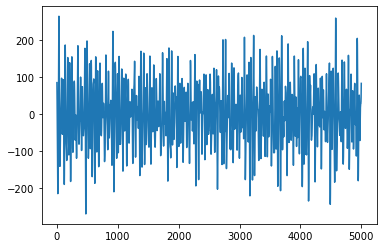

In [411]:
plt.plot(signal[50000:55000])

In [412]:
harm_pd[['f_idx']].values[0:10]

array([[1442. ],
       [ 992.5],
       [1556. ],
       [1104.5],
       [2016. ],
       [ 991.5],
       [1670. ],
       [1216.5],
       [ 221. ],
       [1554. ]])

In [413]:
harm_pd[['f_idx']].values/min(harm_pd[['f_idx']].values)[0]*2

array([[13.04977376],
       [ 8.98190045],
       [14.08144796],
       [ 9.99547511],
       [18.24434389],
       [ 8.97285068],
       [15.11312217],
       [11.00904977],
       [ 2.        ],
       [14.06334842],
       [13.04072398],
       [15.1040724 ],
       [11.        ],
       [10.96832579],
       [12.01357466],
       [18.22624434],
       [10.97737557],
       [12.02262443],
       [ 8.9638009 ],
       [12.9638009 ],
       [ 3.99095023],
       [ 5.98190045],
       [15.13122172],
       [ 2.99095023],
       [18.26244344]])

In [414]:
Play(Create_signal(harm_pd[['f_idx']].values[0:25] ,harm_pd[[0]].values[0:25]))

KeyError: "None of [Int64Index([0], dtype='int64')] are in the [columns]"

### Footprint of harmonics for a C2 note

In [56]:
h_footprint=np.array(harm_pd['f_idx'].values/65.4)
a_footprint=np.array(harm_pd['f_pwr'].values)

In [444]:
Play(Create_signal(h_footprint*notes_df[notes_df['name']=="C-2"][['frec']].values[0][0],a_footprint))

NameError: name 'a_footprint' is not defined

In [59]:
Play(Create_signal(np.round(h_footprint,2)*notes_df[notes_df['name']=="C-2"][['frec']].values[0][0],a_footprint))

In [445]:
harm_pd.head()

,f_idx,f_pwr,f_pwr_2,f_pwr_3,max_freq,note
0,1442.0,3.095368e+06,8.904460e+05,2.804045e+06,1,F#-6 ~-45%
1,992.5,3.083490e+06,4.802877e+05,2.190066e+06,1,B-5 ~8%
3,1556.0,2.435905e+06,2.124995e+06,1.256873e+06,1,G-6 ~-13%
4,1104.5,2.337408e+06,1.476604e+06,1.544903e+06,1,C#-6 ~-7%
12,2016.0,1.243786e+06,3.568770e+05,6.727855e+05,1,B-6 ~35%


In [446]:
notes_df[notes_df['name']=="C-2"][['frec']].values[0][0]

65.4063913251497

In [61]:
h_footprint

array([14.08256881, 24.08256881, 15.10703364, 23.53975535,  7.0030581 ,
       17.1941896 , 10.01529052, 22.46941896, 13.00458716, 18.23394495,
       31.23853211,  3.00458716, 13.05810398, 19.28134557,  6.00152905,
       33.34862385, 21.40672783, 22.04892966, 11.02446483, 37.54587156,
        9.00611621, 33.47859327, 19.01376147, 19.25840979, 40.4204893 ])

In [852]:
## SAVES A NEW FOOTPRINT
footprint_C2 = pd.DataFrame({'harm': h_footprint,'amp': a_footprint}).sort_values('harm')
footprint_C2['index']=np.arange(len(h_footprint))
footprint_C2.set_index('index',inplace=True)
footprint_C2.to_csv('footprint_C2.csv')


In [432]:
h_footprint=pd.read_csv('footprint_C2.csv')

In [447]:
Play(Create_signal(h_footprint['harm']*65., h_footprint['amp']))

In [433]:
np.round(h_footprint,1)

,index,harm,amp
0,0,2.0,723670.2
1,1,3.0,1558307.1
2,2,5.0,827036.5
3,3,6.0,903257.1
4,4,7.0,1821525.0
5,5,9.0,1424605.6
6,6,10.0,2418249.8
7,7,11.0,1146885.1
8,8,12.0,602339.4
9,9,13.0,1318819.5


In [803]:
np.round(np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9])*2,0)/2

array([0. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 1. ])

In [14]:
tunner(130.5)

'C-3 ~-4%'

In [15]:
np.fft.fftfreq(fs*seconds,d=1/fs)[0:fs*seconds//2]

array([0.00000e+00, 5.00000e-01, 1.00000e+00, ..., 2.55985e+04,
       2.55990e+04, 2.55995e+04])

In [16]:
np.fft.fftfreq(10*2,d=2/10)[0:10*2//2] # How do I improve the precission of the frequencies??

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25])

In [736]:
np.fft.fftfreq(10*2,1/10)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5, -5. ,
       -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5])

In [740]:
np.fft.fftfreq((10//2)*(2*2),1/(10/2))

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25])

In [64]:
max(np.frombuffer(frames_list[3],np.int16))-min(np.frombuffer(frames_list[3],np.int16))

9

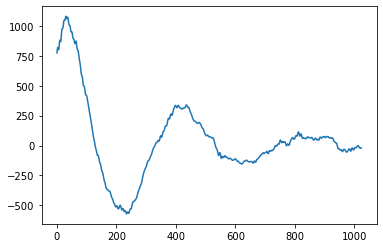

In [62]:
plt.plot(np.frombuffer(frames_list[5],np.int16))

## Creating a Sound 
### The manual process that led to the creation of the function Create_signal() 

In [613]:
t_signal = np.zeros(fs*seconds, dtype=np.int16)
#t_signal[440*seconds] = 1000
#t_signal[880*seconds] = 1500
count = 0
for i in (harm_pd['f_idx'].values*2):
    t_signal[int(i)]=harm_pd[0].values[count]
    count+=1
for i in range(1,int(len(t_signal)/2),1):
    t_signal[-i]=t_signal[i]

In [614]:
signal_=np.real(np.fft.ifft(t_signal))
signal_*=np.iinfo(np.int16).max/max(signal_)
x=np.arange(0,fs*seconds)
fade= 2-2/(np.exp(-x/fs*seconds)+1)
signal_*=fade
signal_*=fade
#signal_[signal_>= np.iinfo(np.int16).max] =  np.iinfo(np.int16).max

signal_=signal_.astype(np.int16)


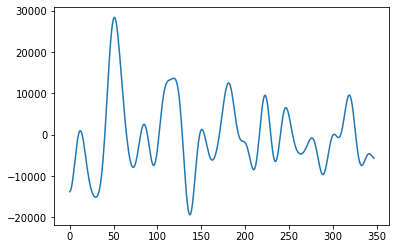

In [615]:
plt.plot(signal_[0:51200//440*3])

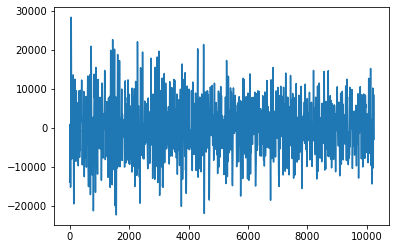

In [616]:
plt.plot(signal_[0:5120*2])

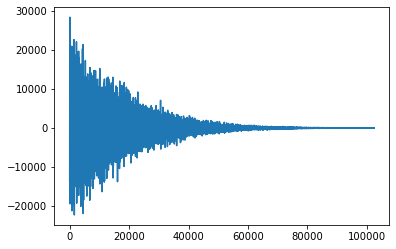

In [617]:
plt.plot(signal_)

In [618]:
Play(signal_)

In [610]:
Play(signal)

## Working with each chunk to and using them as samples

In [673]:
ft_list = []
for line in frames_list:
    ft_list.append(np.abs(np.fft.fft(np.frombuffer(line,np.int16)))[0:fmax_chunk])
ft_pandas = pd.DataFrame(ft_list,columns=f_idx_ch)

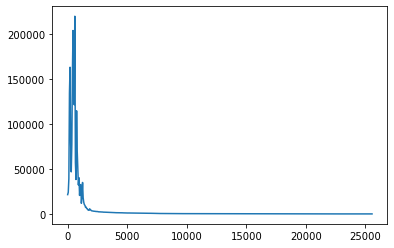

In [674]:
plt.plot(ft_pandas.mean())

In [675]:
pd.DataFrame(ft_pandas.mean()).nlargest(5,0)

,0
600.0,219524.473280
450.0,203688.419379
200.0,162990.285241
400.0,157640.542583
500.0,137117.810734


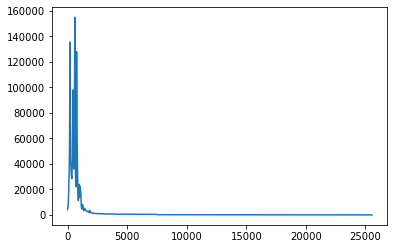

In [676]:
plt.plot(ft_pandas.median())

In [677]:
pd.DataFrame(ft_pandas.median()).nlargest(5,0)

,0
600.0,154982.237558
200.0,135670.310485
750.0,127939.739598
450.0,98030.485277
500.0,72399.995822


## A simpler wave to determine the main frequencies

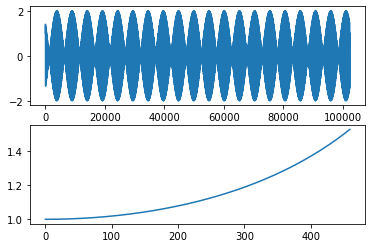

In [182]:
t = np.linspace(0,seconds,fs*seconds)              # A period split in the same samples as the original file
f = np.sin(440*2*np.pi*t)+np.cos(450*2*np.pi*t)    # The wave
Tf = np.fft.fft(f)                                 # The wave's transform 
Freqs = abs(Tf[0:round(fmax)])
FFT2 = pd.DataFrame(Freqs)
FFT2['f_idx'] = f_idx
FFT2.set_index('f_idx',inplace=True)
fig2, ax2 = plt.subplots(2,1)
ax2[0].plot(f)
ax2[1].plot(abs(Tf[0:int(FFT2.idxmax()+10)]))

<AxesSubplot:xlabel='f_idx'>

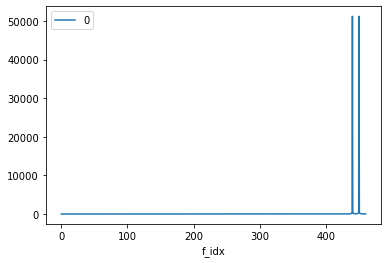

In [183]:
FFT2[0:int(FFT2.idxmax()+10)].plot()

In [184]:
FFT2.nlargest(10,0)

,0
f_idx,
450.0,51193.749212
440.0,51193.535157
450.5,454.182295
449.5,446.890999
440.5,444.658452
439.5,436.490215
451.0,226.623583
449.0,225.596000
441.0,222.609753


In [216]:
Play(f)

In [409]:
2-2/(np.exp(-x/fs*seconds)+1)

array([1.        , 0.99998047, 0.99996094, ..., 0.03597656, 0.03597518,
       0.0359738 ])

In [548]:
 np.iinfo(np.int16).max

32767

In [411]:
len(signal_)

102400

In [443]:
np.exp(complex('j')*np.pi/4)

(0.7071067811865476+0.7071067811865476j)

## Saving a file

In [ ]:
# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()